In [1]:
# === 03_model_train: universal header + config + loads ===
import sys, yaml
from pathlib import Path

# 1) Make src/ importable regardless of where you opened the notebook
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

# 2) Autoreload for iterative edits
%load_ext autoreload
%autoreload 2

# 3) Imports
from utils import print_run_header, read_parquet
print_run_header("03_model_train")

# 4) Load config
CFG_PATH = PROJECT_ROOT / "configs" / "config.yaml"
assert CFG_PATH.exists(), f"Missing config at {CFG_PATH}"
cfg = yaml.safe_load(CFG_PATH.read_text())

# 5) Load processed artifacts from 02_feature_store
PROC_DIR = PROJECT_ROOT / cfg["paths"]["processed_dir"]

labels_path = PROC_DIR / "labels.parquet"
team_path   = PROC_DIR / "team_features.parquet"
starter_path= PROC_DIR / "starter_features.parquet"
lineup_path = PROC_DIR / "lineup_features.parquet"
pitch_path  = PROC_DIR / "pitch_features.parquet"
pw_path     = PROC_DIR / "park_weather_features.parquet"  # may not exist if weather was skipped

for p in [labels_path, team_path, starter_path, lineup_path, pitch_path]:
    assert p.exists(), f"Missing required file: {p}"

labels = read_parquet(labels_path)
team   = read_parquet(team_path)
starter= read_parquet(starter_path)
lineup = read_parquet(lineup_path)
pitch  = read_parquet(pitch_path)

# Weather/park may be skipped; build a neutral fallback if absent
if pw_path.exists():
    pw = read_parquet(pw_path)
else:
    import pandas as pd
    pw = pd.DataFrame({
        "game_id": labels["game_id"],
        "game_pk": labels["game_pk"],
        "temp_c": 20.0,
        "rel_humidity": 50.0,
        "wind_kph": 8.0,
        "mslp_hpa": 1015.0,
        "park_factor_runs": 1.0,
        "air_density_proxy": 1.0,
    })
    print("Note: using neutral park/weather fallback (no weather features).")

print("Loaded shapes:",
      "labels", labels.shape,
      "team", team.shape,
      "starter", starter.shape,
      "lineup", lineup.shape,
      "pitch", pitch.shape,
      "pw", pw.shape)


=== 03_model_train ===
Python 3.12.7 | pandas 2.3.1 | numpy 2.2.6 | sklearn 1.7.1 | xgboost 3.0.4
Platform: Windows 11 | Time: 2025-08-21 19:35:23
Note: using neutral park/weather fallback (no weather features).
Loaded shapes: labels (8680, 7) team (8680, 4) starter (8680, 4) lineup (8680, 4) pitch (8680, 4) pw (8680, 8)


In [3]:
for nm, df_ in [("labels", labels), ("team", team), ("starter", starter), ("lineup", lineup), ("pitch", pitch), ("pw", pw)]:
    missing = [c for c in ["game_id", "game_pk"] if c not in df_.columns]
    print(nm, "missing:", missing)


labels missing: []
team missing: []
starter missing: []
lineup missing: []
pitch missing: []
pw missing: []


In [5]:
keys = ["game_id", "game_pk"]

def dup_report(df, name):
    dups = df.duplicated(keys).sum()
    uniq = df.drop_duplicates(keys).shape[0]
    print(f"{name:8s}  rows={len(df):5d}  dup_key_rows={dups:5d}  unique_games={uniq}")

for nm, df_ in [("labels", labels), ("team", team), ("starter", starter),
                ("lineup", lineup), ("pitch", pitch), ("pw", pw)]:
    dup_report(df_, nm)


labels    rows= 8680  dup_key_rows=    0  unique_games=8680
team      rows= 8680  dup_key_rows=    0  unique_games=8680
starter   rows= 8680  dup_key_rows=    0  unique_games=8680
lineup    rows= 8680  dup_key_rows=    0  unique_games=8680
pitch     rows= 8680  dup_key_rows=    0  unique_games=8680
pw        rows= 8680  dup_key_rows=    0  unique_games=8680


In [7]:
keys = ["game_id", "game_pk"]

def normalize_keys(df, name):
    # 1) drop exact duplicate-named columns, keep first
    df = df.loc[:, ~df.columns.duplicated(keep="first")].copy()

    # 2) coalesce suffix variants like game_id_x/game_id_y -> game_id
    for base in keys:
        x, y = f"{base}_x", f"{base}_y"
        if x in df.columns or y in df.columns:
            if base not in df.columns:
                df[base] = df.get(x, df.get(y))
            # if both exist, prefer _x but fill from _y where _x is NA
            if x in df.columns and y in df.columns:
                df[base] = df[base].where(~df[base].isna(), df[y])
            df.drop(columns=[c for c in [x, y] if c in df.columns], inplace=True)

        # if somehow there are still multiple columns with the same base name,
        # keep the first one
        if isinstance(df.get(base), pd.DataFrame):
            first = df[base].iloc[:, 0]
            df.drop(columns=[base], inplace=True)
            df[base] = first

    # ensure both keys exist; if not, try to build from the other tables later
    missing = [k for k in keys if k not in df.columns]
    if missing:
        print(f"[{name}] missing keys after normalize:", missing)
    return df

labels  = normalize_keys(labels,  "labels")
team    = normalize_keys(team,    "team")
starter = normalize_keys(starter, "starter")
lineup  = normalize_keys(lineup,  "lineup")
pitch   = normalize_keys(pitch,   "pitch")
pw      = normalize_keys(pw,      "pw")


In [9]:
def backfill_keys_from_labels(df, name):
    need = [k for k in keys if k not in df.columns]
    if need:
        df = df.merge(
            labels[keys].drop_duplicates(keys),
            on="game_id",
            how="left",
            validate="many_to_one",
        )
        print(f"[{name}] backfilled keys from labels.")
    return df

team    = backfill_keys_from_labels(team,    "team")
starter = backfill_keys_from_labels(starter, "starter")
lineup  = backfill_keys_from_labels(lineup,  "lineup")
pitch   = backfill_keys_from_labels(pitch,   "pitch")
pw      = backfill_keys_from_labels(pw,      "pw")


In [11]:
def dup_report(df, name):
    dups = df.duplicated(keys).sum()
    uniq = df.drop_duplicates(keys).shape[0]
    print(f"{name:8s} rows={len(df):5d}  dup_key_rows={dups:5d}  unique_games={uniq}")

for nm, df_ in [("labels", labels), ("team", team), ("starter", starter),
                ("lineup", lineup), ("pitch", pitch), ("pw", pw)]:
    dup_report(df_, nm)


labels   rows= 8680  dup_key_rows=    0  unique_games=8680
team     rows= 8680  dup_key_rows=    0  unique_games=8680
starter  rows= 8680  dup_key_rows=    0  unique_games=8680
lineup   rows= 8680  dup_key_rows=    0  unique_games=8680
pitch    rows= 8680  dup_key_rows=    0  unique_games=8680
pw       rows= 8680  dup_key_rows=    0  unique_games=8680


In [13]:
def squash_to_game(df, name):
    if df.duplicated(keys).any():
        num_cols = df.select_dtypes(include="number").columns.tolist()
        keep = list(dict.fromkeys(keys + num_cols))  # preserve order, drop repeats
        out = (df[keep]
               .groupby(keys, as_index=False)
               .mean(numeric_only=True))
        print(f"{name}: squashed {len(df)} → {len(out)} rows (per game).")
        return out
    else:
        print(f"{name}: already per-game.")
        return df

team    = squash_to_game(team,    "team")
starter = squash_to_game(starter, "starter")
lineup  = squash_to_game(lineup,  "lineup")   # usually already per-game, but safe
pitch   = squash_to_game(pitch,   "pitch")
pw      = squash_to_game(pw,      "pw")


team: already per-game.
starter: already per-game.
lineup: already per-game.
pitch: already per-game.
pw: already per-game.


In [15]:
for nm, df_ in [("team", team), ("starter", starter), ("lineup", lineup), ("pitch", pitch), ("pw", pw)]:
    assert not df_.duplicated(keys).any(), f"{nm} still has duplicate game rows"


In [17]:
from markov import build_first_inning_prior
prior = build_first_inning_prior(labels, team, starter, lineup, pw)
prior.describe()


count    8680.000000
mean        0.312701
std         0.001375
min         0.306651
25%         0.311787
50%         0.312701
75%         0.313601
max         0.318222
Name: prior_y1, dtype: float64

In [19]:
# reload model code just in case you've edited anything
import importlib, model
importlib.reload(model)
from model import train_hybrid_model


In [20]:
# train the hybrid model
artifacts = train_hybrid_model(
    labels=labels,
    features=[team, starter, lineup, pitch, pw],
    prior=prior,
    cfg=cfg
)

# confirm where the model got saved
artifacts["model_path"]


Fold 1: Brier 0.2484 | LogLoss 0.6900 | AUC 0.523 | alpha 0.05 beta -0.02
Fold 2: Brier 0.2489 | LogLoss 0.6910 | AUC 0.522 | alpha 0.01 beta 0.17
Fold 3: Brier 0.2482 | LogLoss 0.6892 | AUC 0.529 | alpha 0.01 beta -0.30


C:\Users\alex\Desktop\nrfi\src\evaluate.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pd.DataFrame({"y": y_true, "p": y_prob, "bin": q}).groupby("bin", as_index=False).agg(


'data\\processed\\model.joblib'

In [23]:
import joblib, pandas as pd
from pathlib import Path

processed_dir = Path(cfg["paths"]["processed_dir"])
art = joblib.load(processed_dir / "model.joblib")["artifacts"]

fold_df = pd.DataFrame(art["fold_info"])
display(fold_df.style.format({"brier": "{:.4f}", "logloss": "{:.4f}", "auc": "{:.3f}",
                              "alpha": "{:.2f}", "beta": "{:.2f}", "bias": "{:.2f}"}))


,fold,brier,logloss,auc,alpha,beta,bias
0,1,0.2484,0.6900,0.523,0.05,-0.02,-0.07
1,2,0.2489,0.6910,0.522,0.01,0.17,-0.01
2,3,0.2482,0.6892,0.529,0.01,-0.30,-0.03


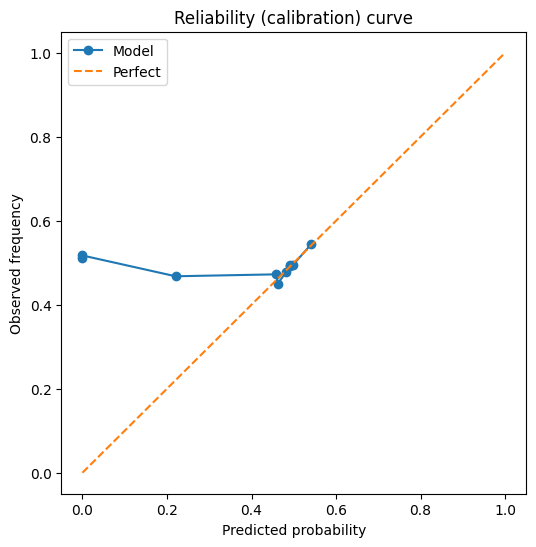

,bin,count,avg_p,hit_rate
0,0,868,0.000,0.512
1,1,868,0.000,0.517
2,2,868,0.220,0.468
3,3,868,0.459,0.472
4,4,868,0.462,0.449
5,5,868,0.481,0.477
6,6,868,0.490,0.492
7,7,868,0.492,0.495
8,8,868,0.499,0.495
9,9,868,0.541,0.544


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pred = pd.read_parquet(processed_dir / "train_predictions.parquet")
pred = pred.rename(columns={"prob_yrfi": "p", "yrfi": "y"})

# Deciles by predicted prob
q = pd.qcut(pred["p"].rank(method="first") / len(pred), q=10, labels=False)
cal = (pd.DataFrame({"y": pred["y"].astype(int), "p": pred["p"], "bin": q})
         .groupby("bin", observed=True)
         .agg(count=("y", "size"), avg_p=("p", "mean"), hit_rate=("y", "mean"))
         .reset_index())

# Plot reliability
plt.figure(figsize=(6, 6))
plt.plot(cal["avg_p"], cal["hit_rate"], marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability (calibration) curve")
plt.legend()
plt.show()

# Show the decile table
cal_style = cal.copy()
cal_style["avg_p"] = cal_style["avg_p"].map("{:.3f}".format)
cal_style["hit_rate"] = cal_style["hit_rate"].map("{:.3f}".format)
display(cal_style)


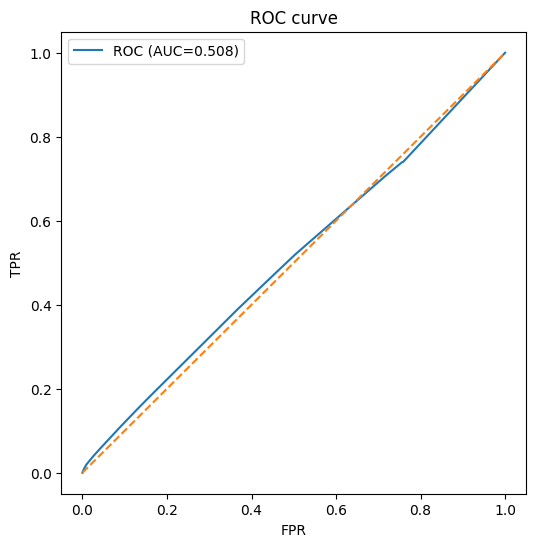

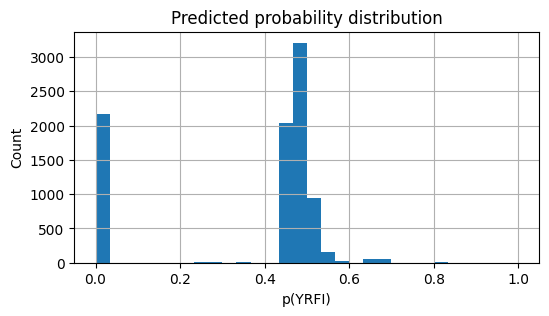

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

auc = roc_auc_score(pred["y"], pred["p"])
fpr, tpr, _ = roc_curve(pred["y"], pred["p"])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
pred["p"].hist(bins=30)
plt.title("Predicted probability distribution")
plt.xlabel("p(YRFI)")
plt.ylabel("Count")
plt.show()


In [32]:
# ===== Data Pipeline Audit (auto-discovers *_feat tables) =====

import pandas as pd
import numpy as np
from pandas.api.types import (
    is_numeric_dtype, is_bool_dtype, is_datetime64_any_dtype, is_datetime64tz_dtype
)

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 120)

def _exist(cols, df): return [c for c in cols if c in df.columns]

def _pick_first_existing(df, candidates):
    for c in candidates or []:
        if c in df.columns:
            return c
    return None

def _dtype_summary(df):
    out = []
    for c in df.columns:
        s = df[c]
        dt = str(s.dtype)
        tz = None
        if is_datetime64tz_dtype(s):
            tz = str(getattr(getattr(s.dt.tz, 'zone', None), 'zone', None) or s.dt.tz)
        out.append({
            "column": c,
            "dtype": dt,
            "is_numeric": bool(is_numeric_dtype(s)),
            "is_bool": bool(is_bool_dtype(s)),
            "is_datetime": bool(is_datetime64_any_dtype(s)),
            "is_datetime_tz": bool(is_datetime64tz_dtype(s)),
            "tz": tz,
            "n_unique": int(s.nunique(dropna=True)),
            "pct_nan": float(s.isna().mean()),
            "has_inf": bool(np.isinf(s.astype("float64", errors="ignore")).any() if is_numeric_dtype(s) else False),
            "is_constant": bool((s.nunique(dropna=True) <= 1))
        })
    return pd.DataFrame(out).sort_values(["pct_nan","column"], ascending=[False,True])

def _dup_check(df, keys, name):
    out = {}
    if not set(keys).issubset(df.columns):
        out["missing_keys"] = list(set(keys) - set(df.columns))
        out["n_dupes_on_keys"] = None
        return out
    key_dupes = df.duplicated(subset=keys, keep=False).sum()
    out["missing_keys"] = []
    out["n_dupes_on_keys"] = int(key_dupes)
    if key_dupes:
        sample = df[df.duplicated(subset=keys, keep=False)].sort_values(keys).head(10)
        print(f"\n[!!] {name}: duplicate key rows (showing up to 10):")
        display(sample)
    return out

def _leakage_check(labels, feat, cfg, feat_name):
    fcol = cfg.get("feature_time_col")
    ecol = cfg.get("event_time_col")
    keys = cfg["keys"]
    if not fcol or not ecol:
        return None
    if any(col not in feat.columns for col in [*keys, fcol]) or ecol not in labels.columns:
        return None

    cols_keep = [*keys, fcol]
    tmp = feat[cols_keep].copy()

    lab_time = labels[ecol]
    if is_datetime64_any_dtype(lab_time) and not is_datetime64tz_dtype(lab_time):
        lab_time = lab_time.dt.tz_localize("UTC")
    elif is_datetime64tz_dtype(lab_time):
        lab_time = lab_time.dt.tz_convert("UTC")

    feat_time = tmp[fcol]
    if is_datetime64_any_dtype(feat_time) and not is_datetime64tz_dtype(feat_time):
        feat_time = feat_time.dt.tz_localize("UTC")
    elif is_datetime64tz_dtype(feat_time):
        feat_time = feat_time.dt.tz_convert("UTC")

    tmp[fcol] = feat_time
    lab = labels[cfg["keys"]].copy()
    lab[ecol] = lab_time

    merged = lab.merge(tmp, on=keys, how="left", validate="one_to_one")
    if fcol not in merged.columns:
        return None

    bad = merged[merged[fcol].notna() & merged[ecol].notna() & (merged[fcol] > merged[ecol])]
    report = {
        "feat": feat_name,
        "n_rows": len(merged),
        "n_with_times": int(merged[fcol].notna().sum()),
        "n_leak_rows": int(len(bad)),
        "leak_rate_pct": float(len(bad) / max(1, len(merged)))
    }
    if len(bad):
        print(f"\n[!!] Potential leakage in {feat_name}: {len(bad)} rows where {fcol} > {ecol} (showing up to 10)")
        display(bad.head(10))
    return report

def _utilization_check(labels, feat, cfg, feat_name):
    keys = cfg["keys"]
    if not set(keys).issubset(labels.columns) or not set(keys).issubset(feat.columns):
        return {"feat": feat_name, "status": "skipped_missing_keys"}

    feat_cols = [c for c in feat.columns if c not in keys]
    if not feat_cols:
        return {"feat": feat_name, "status": "no_feature_cols"}

    merged = labels[keys].merge(feat, on=keys, how="left")
    nan_pct = merged[feat_cols].isna().mean().sort_values(ascending=False)
    const_mask = merged[feat_cols].nunique(dropna=True) <= 1

    warn_pct = cfg.get("nan_warn_pct", 0.30)
    heavy_nan = nan_pct[nan_pct >= warn_pct]
    const_cols = list(nan_pct.index[const_mask])

    if len(heavy_nan):
        print(f"\n[!] {feat_name}: columns with >= {int(warn_pct*100)}% NaNs after merge:")
        display(heavy_nan.to_frame("nan_pct").head(20))
    if len(const_cols):
        print(f"\n[!] {feat_name}: constant columns after merge (first 20): {const_cols[:20]}")

    return {
        "feat": feat_name,
        "n_label_rows": int(len(labels)),
        "n_feat_rows": int(len(feat)),
        "n_merged_rows": int(len(merged)),
        "n_feature_cols": int(len(feat_cols)),
        "n_heavy_nan_cols": int(len(heavy_nan)),
        "n_const_cols": int(const_mask.sum()),
    }

def audit_pipeline(tables: dict, cfg: dict):
    keys = cfg["keys"]
    labels = tables.get("labels")
    assert labels is not None, "tables['labels'] is required"

    print("==[ A. Labels sanity ]==")
    print(f"Rows: {len(labels):,}")
    print(f"Keys: {keys}")
    target = _pick_first_existing(labels, cfg.get("target_candidates"))
    print(f"Target column: {target or 'not found'}")

    lab_dtypes = _dtype_summary(labels)
    display(lab_dtypes.head(cfg.get("max_preview_rows", 8)))

    lab_dupes = _dup_check(labels, keys, "labels")
    if lab_dupes.get("missing_keys"):
        print(f"[!!] labels missing keys: {lab_dupes['missing_keys']}")

    ecol = cfg.get("event_time_col")
    if ecol and ecol in labels.columns:
        s = labels[ecol]
        tzinfo = "tz-aware" if is_datetime64tz_dtype(s) else ("datetime" if is_datetime64_any_dtype(s) else str(s.dtype))
        print(f"Event time col '{ecol}': dtype={s.dtype} ({tzinfo}), nulls={int(s.isna().sum())}/{len(s)}")
        if is_datetime64tz_dtype(s):
            print(f"  time range: {s.min()}  ->  {s.max()}")
    elif ecol:
        print(f"[!] Event time col '{ecol}' not in labels; leakage checks will be skipped.")

    print("\n==[ B. Feature tables sanity ]==")
    util_reports = []
    for name, df in tables.items():
        if name == "labels":
            continue
        print(f"\n-- {name} --  rows={len(df):,}")
        display(_dtype_summary(df).head(cfg.get("max_preview_rows", 8)))
        rep = _dup_check(df, keys, name)
        if rep.get("missing_keys"):
            print(f"[!!] {name} missing keys: {rep['missing_keys']}")
        leak_rep = _leakage_check(labels, df, cfg, name)
        if leak_rep:
            util_reports.append({"_kind":"leakage", **leak_rep})
        util_rep = _utilization_check(labels, df, cfg, name)
        util_reports.append({"_kind":"utilization", **util_rep})

    if util_reports:
        util_df = pd.DataFrame(util_reports)
        print("\n==[ C. Utilization / Leakage summary ]==")
        display(util_df.sort_values(["_kind","feat"]).reset_index(drop=True))

    print("\n==[ D. Merge preview (labels + each feature) ]==")
    for name, df in tables.items():
        if name == "labels":
            continue
        if not set(keys).issubset(labels.columns) or not set(keys).issubset(df.columns):
            print(f"- {name}: skipped (missing keys)")
            continue
        merged = labels.merge(df, on=keys, how="left")
        print(f"- {name}: merged shape {merged.shape}, feature cols added: {len([c for c in df.columns if c not in keys])}")
        show_cols = [*keys]
        ecol = cfg.get("event_time_col")
        fcol = cfg.get("feature_time_col")
        if ecol and ecol in merged.columns: show_cols.append(ecol)
        if fcol and fcol in merged.columns: show_cols.append(fcol)
        show_cols += [c for c in merged.columns if c not in set(show_cols + keys)][:5]
        display(merged[show_cols].head(cfg.get("max_preview_rows", 8)))

    print("\n==[ E. Done ]==")

# ==== Build TABLES dynamically ====
try:
    labels  # noqa
except NameError as e:
    raise RuntimeError("You must define `labels` before running the audit.") from e

TABLES = {"labels": labels}
# Auto-include any DataFrame variable whose name ends with "_feat"
for _name, _obj in list(globals().items()):
    if _name.endswith("_feat") and isinstance(_obj, pd.DataFrame):
        TABLES[_name] = _obj

print("Discovered feature tables:", [k for k in TABLES.keys() if k != "labels"] or "[none]")

AUDIT_CFG = {
    "keys": ["game_id", "game_pk"],            # adjust if yours differ
    "event_time_col": "game_datetime_utc",     # labels time col
    "feature_time_col": "asof_time",           # feature time col
    "target_candidates": ["label", "y", "nrfi"],
    "nan_warn_pct": 0.30,
    "max_preview_rows": 8,
}

audit_pipeline(TABLES, AUDIT_CFG)


Discovered feature tables: [none]
==[ A. Labels sanity ]==
Rows: 8,680
Keys: ['game_id', 'game_pk']
Target column: not found


C:\Users\alex\AppData\Local\Temp\ipykernel_1656\330250499.py:26: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s):
C:\Users\alex\AppData\Local\Temp\ipykernel_1656\330250499.py:34: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  "is_datetime_tz": bool(is_datetime64tz_dtype(s)),
C:\Users\alex\AppData\Local\Temp\ipykernel_1656\330250499.py:26: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s):
C:\Users\alex\AppData\Local\Temp\ipykernel_1656\330250499.py:34: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  "is_datetime_tz"

,column,dtype,is_numeric,is_bool,is_datetime,is_datetime_tz,tz,n_unique,pct_nan,has_inf,is_constant
3,away_team,object,False,False,False,False,None,30,0.0,False,False
0,date,datetime64[ns],False,False,True,False,None,707,0.0,False,False
6,game_datetime_utc,"datetime64[ns, UTC]",False,False,True,True,UTC,2615,0.0,False,False
1,game_id,object,False,False,False,False,None,8510,0.0,False,False
2,game_pk,Int64,True,False,False,False,None,8680,0.0,False,False
4,home_team,object,False,False,False,False,None,30,0.0,False,False
5,yrfi,int64,True,False,False,False,None,2,0.0,False,False


Event time col 'game_datetime_utc': dtype=datetime64[ns, UTC] (tz-aware), nulls=0/8680
  time range: 2021-04-01 19:00:00+00:00  ->  2024-05-16 02:00:00+00:00

==[ B. Feature tables sanity ]==

==[ D. Merge preview (labels + each feature) ]==

==[ E. Done ]==


C:\Users\alex\AppData\Local\Temp\ipykernel_1656\330250499.py:157: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  tzinfo = "tz-aware" if is_datetime64tz_dtype(s) else ("datetime" if is_datetime64_any_dtype(s) else str(s.dtype))
C:\Users\alex\AppData\Local\Temp\ipykernel_1656\330250499.py:159: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s):
